In [1]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

import torch
from torchinfo import summary
from torch.utils.data import DataLoader

from models.vae_trainer import VAETrainer

In [2]:
DATASET_PATH = os.path.join(os.getcwd(), 'data')

In [3]:
seed = 37
torch.manual_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class SensorDataset():
    def __init__(self, data: np.array):
        self.x = self.np2tensor(data)
        
    @staticmethod
    def np2tensor(x):
        return torch.tensor(x, dtype=torch.float32)
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]

In [5]:
latent_dims = 118
batch_size = 16
epochs = 1000

In [6]:
data_filename = 'data.mat'
data = loadmat(os.path.join(DATASET_PATH, data_filename))
Z = data['Z']
T = len(Z)
train_size = int(T * 0.8)
lr = 1e-1
scheduler = True
es_patience = 10

In [7]:
Z_train, Z_test = Z[:train_size], Z[train_size:]
training = SensorDataset(Z_train)
test = SensorDataset(Z_test)
train_dl = DataLoader(training, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test)

In [9]:
trainer = VAETrainer(latent_dim=latent_dims, lr=lr, 
                     lr_scheduler=scheduler, es_patience=es_patience,
                     checkpoint_name = 'vae_0%.pt', 
                     seed=seed)

Device:  cuda


In [10]:
summary(trainer.vae, (1, 358))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 358]                  --
├─VariationalEncoder: 1-1                [1, 118]                  --
│    └─Linear: 2-1                       [1, 236]                  84,724
│    └─BatchNorm1d: 2-2                  [1, 236]                  472
│    └─Linear: 2-3                       [1, 118]                  27,966
│    └─Linear: 2-4                       [1, 118]                  14,042
│    └─Linear: 2-5                       [1, 118]                  14,042
├─Decoder: 1-2                           [1, 358]                  --
│    └─Linear: 2-6                       [1, 236]                  28,084
│    └─BatchNorm1d: 2-7                  [1, 236]                  472
│    └─Linear: 2-8                       [1, 358]                  84,846
Total params: 254,648
Trainable params: 254,648
Non-trainable params: 0
Total mult-adds (M): 0.25
Input size (MB): 0.00
Forward/b

In [11]:
vae, mse, kl, val_mse, val_kl = trainer.train(train_dl, test_dl, epochs=epochs)

Epoch 1/1000: [MSE: 1.5061], [KL: 1.1694], [Val_MSE: 0.1353], [Val_KL: 0.3652], 
Validation loss decreased (inf --> 0.135257).  Saving model ...
Epoch 2/1000: [MSE: 0.1279], [KL: 0.3659], [Val_MSE: 0.1174], [Val_KL: 0.3904], 
Validation loss decreased (0.135257 --> 0.117406).  Saving model ...
Epoch 3/1000: [MSE: 0.1195], [KL: 0.3648], [Val_MSE: 0.1251], [Val_KL: 0.3705], 
EarlyStopping counter: 1 out of 10
Epoch 4/1000: [MSE: 0.1186], [KL: 0.3629], [Val_MSE: 0.1136], [Val_KL: 0.3731], 
Validation loss decreased (0.117406 --> 0.113617).  Saving model ...
Epoch 5/1000: [MSE: 0.1088], [KL: 0.3614], [Val_MSE: 0.1139], [Val_KL: 0.3628], 
EarlyStopping counter: 1 out of 10
Epoch 6/1000: [MSE: 0.1159], [KL: 0.3617], [Val_MSE: 0.1037], [Val_KL: 0.3649], 
Validation loss decreased (0.113617 --> 0.103653).  Saving model ...
Epoch 7/1000: [MSE: 0.1080], [KL: 0.3604], [Val_MSE: 0.0965], [Val_KL: 0.3640], 
Validation loss decreased (0.103653 --> 0.096513).  Saving model ...
Epoch 8/1000: [MSE: 0.1

In [20]:
def plot_learning(mse, kl, val_mse, val_kl):
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    axs[0].plot(mse, color='r', label='Training')
    axs[0].plot(val_mse, color='b', label='Validation')
    axs[0].set_title('MSE Loss')
    axs[1].plot(kl, color='r', label='Training')
    axs[1].plot(val_kl, color='b', label='Validation')
    axs[1].set_title('KL Loss')
    plt.legend()
    #plt.savefig('./imgMix/mse-kl-mvae.pdf', format='pdf', dpi=1200)
    plt.show()

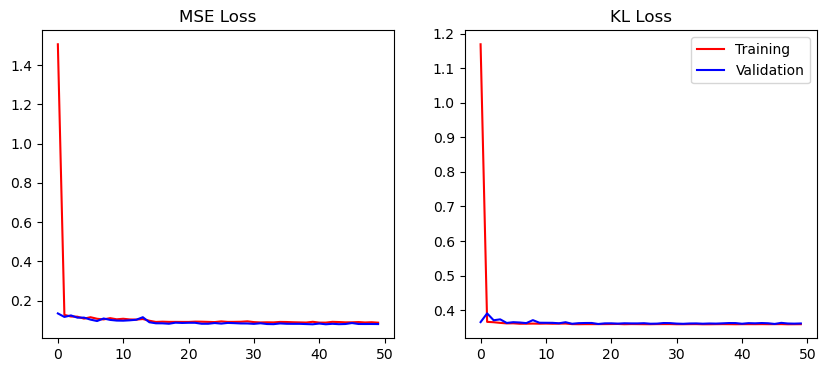

In [21]:
plot_learning(mse, kl, val_mse, val_kl)

In [22]:
vae.eval()
Z = torch.tensor(Z, dtype=torch.float32).to(device)
Z_enc = vae(Z)

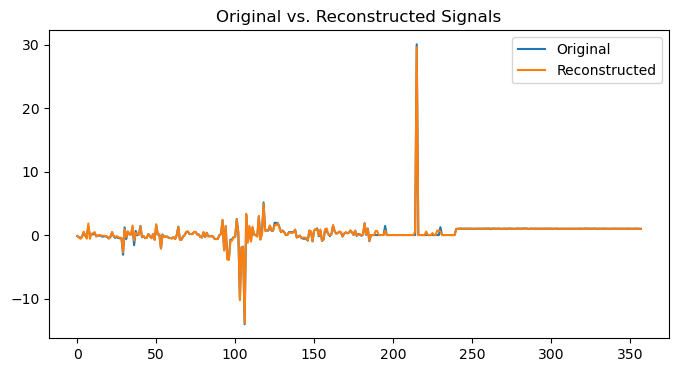

In [23]:
idx = 0
fig, axs = plt.subplots(figsize=(8,4))
axs.plot(np.transpose(Z[idx,:].cpu().detach().numpy()), label='Original')
axs.plot(np.transpose(Z_enc[idx,:].cpu().detach().numpy()), label='Reconstructed')
axs.set_title('Original vs. Reconstructed Signals')
plt.legend()
plt.show()

In [24]:
vae.eval()
Z_latent = vae.encoder(Z)

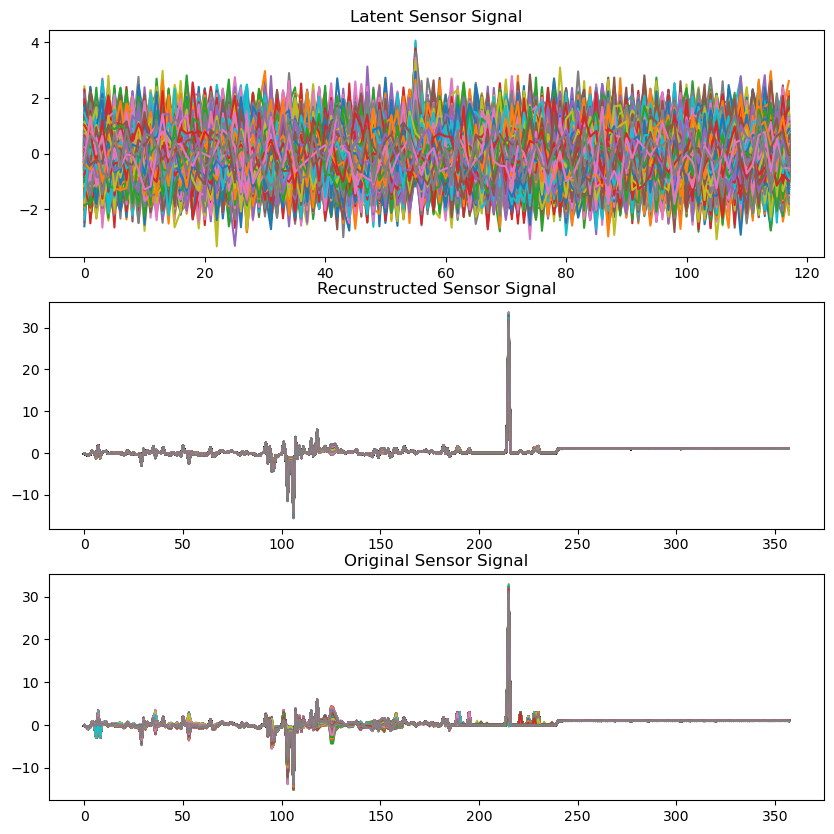

In [25]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
axs[0].plot(np.transpose(Z_latent.cpu().detach().numpy()))
axs[0].set_title('Latent Sensor Signal')
axs[1].plot(np.transpose(Z_enc.cpu().detach().numpy()))
axs[1].set_title('Recunstructed Sensor Signal')
axs[2].plot(np.transpose(Z.cpu().detach().numpy()))
axs[2].set_title('Original Sensor Signal')
plt.show()

**$t=1$ latent distribution**

In [26]:
vae.eval()
sample_size = 30
signal = Z[0:2]
signal_latent, signal_rec = [], []
for _ in range(sample_size):
    signal_rec.append(vae(signal))
    signal_latent.append(vae.encoder(signal))
signal_latent = torch.stack(signal_latent, dim=0)
signal_rec = torch.stack(signal_rec, dim=0)

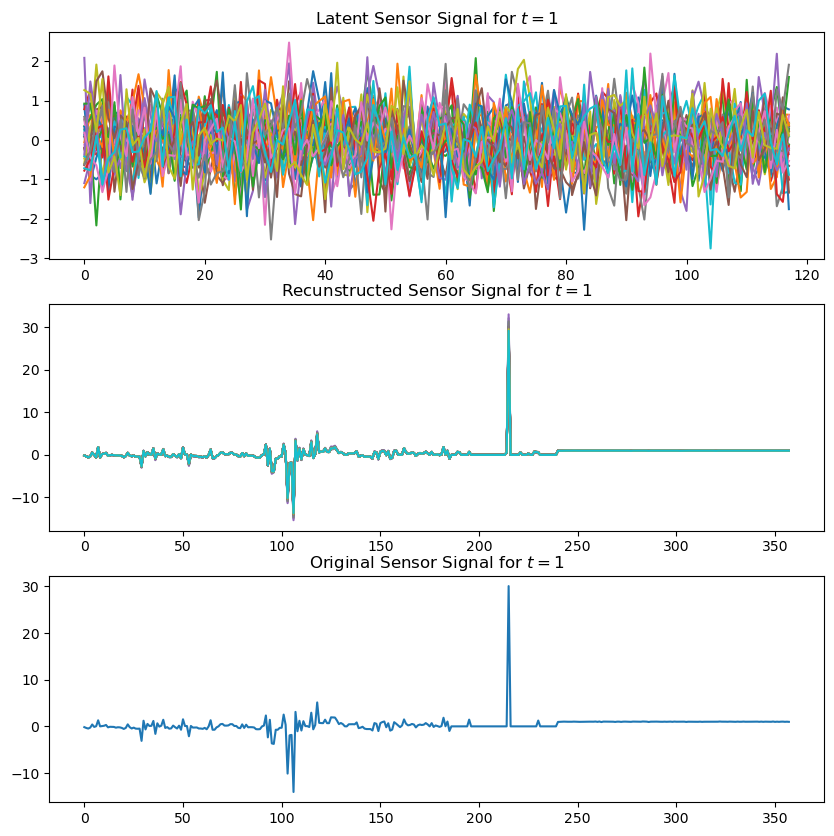

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
axs[0].plot(np.transpose(signal_latent.cpu().detach().numpy()[:,0,:]))
axs[0].set_title(r'Latent Sensor Signal for $t=1$')
axs[1].plot(np.transpose(signal_rec.cpu().detach().numpy()[:,0,:]))
axs[1].set_title(r'Recunstructed Sensor Signal for $t=1$')
axs[2].plot(np.transpose(signal.cpu().detach().numpy()[0]))
axs[2].set_title(r'Original Sensor Signal for $t=1$')
plt.show()